In [2]:
from tensorflow.keras.utils    import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder, StandardScaler


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 420

tf.random.set_seed(seed)
np.random.seed    (seed)

In [2]:
print(os.environ['PATH'])

/tools/Xilinx/Vivado/2019.1/bin:/home/fang/anaconda3/envs/hls4ml-tutorial/bin:/home/fang/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/tools/Xilinx/Vivado/2019.1/bin


In [3]:
USER_PATH    = os.getcwd()
DATA_PATH    = os.path.join(USER_PATH, "Data")
MODEL_PATH   = os.path.join(USER_PATH, "Models")
PROJECT_PATH = os.path.join(USER_PATH, "HLS_projects")
PLOTS_PATH   = os.path.join(USER_PATH, "Plots")

# 需要检查的路径列表
paths = [DATA_PATH, MODEL_PATH, PROJECT_PATH, PLOTS_PATH]

# 检查每个路径是否存在，如果不存在则创建
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")

Created directory: /home/fang/PycharmProjects/cnn_bo/Data
Created directory: /home/fang/PycharmProjects/cnn_bo/Models
Created directory: /home/fang/PycharmProjects/cnn_bo/HLS_projects
Created directory: /home/fang/PycharmProjects/cnn_bo/Plots


In [4]:
from tensorflow.keras.models       import Sequential
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers       import Activation, BatchNormalization, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers       import Dense, Conv2D

from utils.callbacks import all_callbacks

from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh, binary_tanh

In [5]:
from tensorflow.keras.datasets import mnist
from qkeras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

In [6]:
from tensorflow.keras.models import model_from_json
from qkeras.utils import _add_supported_quantized_objects; co = {}; _add_supported_quantized_objects(co)

def get_example_cnn_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_cnn.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_cnn_weights.h5')

    print_qstats(model)

    return model

def get_example_dense_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_dense.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_dense_weights.h5')

    print_qstats(model)

    return model

def get_cnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = QConv2D(
        8, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_1")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    #x = Conv2D(36, (3,3),
    #          name='Conv2')(x)
    #x = MaxPool2D((2,2), name='Max2')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

def get_dense_qmodel():
    x = x_in = Input((784,), name="layer0")
    x = QActivation("quantized_relu(2)", name="q_relu")(x)
    x = QDense(
        20,
        kernel_quantizer = quantized_bits(4,0, alpha=1),
        bias_quantizer   = quantized_bits(5,0, alpha=1),
        name="q_dense")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = QDense(
        10,
        kernel_quantizer = quantized_bits(4,1, alpha=1),
        bias_quantizer   = quantized_bits(4,1, alpha=1),
        name='q_dense_1')(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

In [7]:
def get_train_test_set(nn_type='Dense'):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = x_train / 256.0
    x_test = x_test / 256.0
    
    if (nn_type=='Dense'):
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
        
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

# Convolutional neural network

### Get the dataset

In [8]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Conv2d')

### Get the model

In [9]:
model = get_cnn_qmodel()

model.summary()

2024-04-23 17:16:21.580996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 139392 (smult_5_3)
    q_dense                       : 2000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 141392

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 1152  (5-bit unit)
    q_conv2d_1_bias                : 8     (6-bit unit)
    q_dense_weights                : 2000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.2250
    q_conv2d_1                     : 0.1879
    q_dense                        : 0.2269
    ----------------------------------------
    Total Sparsity                 : 0.2132
Model: "model"
_____________________________________________________

### Set the pruning parameters

In [10]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=360, frequency=180)}
model = prune.prune_low_magnitude(model, **pruning_params)

### Train the model

In [11]:
train = True
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/gpu:0'):
        model.fit(x_train, y_train, batch_size=5000,
                  epochs=50, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

Epoch 1/50
9/9 [==============================] - 28s 2s/step - loss: 2.3364 - accuracy: 0.1195 - val_loss: 2.3276 - val_accuracy: 0.1253 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 9s 809ms/step - loss: 2.3267 - accuracy: 0.1237 - val_loss: 2.3103 - val_accuracy: 0.1276 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 7s 762ms/step - loss: 2.3121 - accuracy: 0.1259 - val_loss: 2.3070 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 7s 737ms/step - loss: 2.1634 - accuracy: 0.2208 - val_loss: 1.8407 - val_accuracy: 0.4611 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 6s 682ms/step - loss: 1.7032 - accuracy: 0.4886 - val_loss: 1.5506 - val_accuracy: 0.5353 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 6s 692ms/step - loss: 1.4993 - accuracy: 0.5582 - val_loss: 1.4235 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 6s 663ms/step - loss: 1.3801 - acc

% of zeros = 0.75

Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 139392 (smult_5_3)
    q_dense                       : 2000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 141392

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 1152  (5-bit unit)
    q_conv2d_1_bias                : 8     (6-bit unit)
    q_dense_weights                : 2000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.7063
    q_conv2d_1                     : 0.7474
    q_dense                        : 0.7473
    ----------------------------------------
    Total Sparsity                 : 0.7453


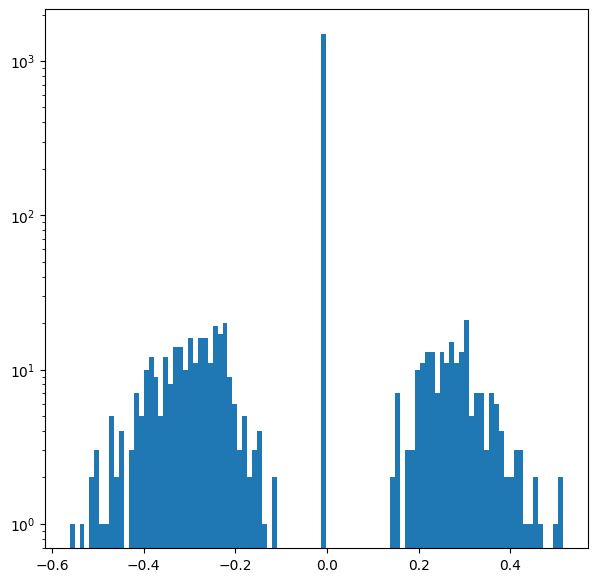

In [12]:
w = model.layers[8].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))




print_qstats(model)

### hls4ml configuration file

In [13]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

Trace = True

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

#config['Backend'] = 'vivado_accelerator' 

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<10,6>'

#config['LayerName']['layer0']['Precision'] = 'ap_ufixed<8,3>'

config['LayerName']['q_conv2d']['ReuseFactor'] = 72
#config['LayerName']['q_conv2d']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_conv2d']['Precision']['bias']     = 'ap_fixed<11,3>'
#config['LayerName']['q_conv2d']['Precision']['result']   = 'ap_fixed<9,3>'
config['LayerName']['q_conv2d']['Trace']       = Trace
config['LayerName']['q_conv2d']['Strategy'] = 'Latency'

#config['LayerName']['maxp']['Precision']   = 'ap_fixed<3,2>'
config['LayerName']['maxp']['Trace']       = Trace

config['LayerName']['q_conv2d_1']['ReuseFactor'] = 72
#config['LayerName']['q_conv2d_1']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_conv2d_1']['Precision']['bias']     = 'ap_fixed<11,3>'
#config['LayerName']['q_conv2d_1']['Precision']['result']   = 'ap_fixed<9,5>'
config['LayerName']['q_conv2d_1']['Trace']       = Trace
config['LayerName']['q_conv2d_1']['Strategy'] = 'Latency'

#config['LayerName']['maxp_1']['Precision']   = 'ap_fixed<3,2>'
config['LayerName']['maxp_1']['Trace']       = Trace

config['LayerName']['q_dense']['ReuseFactor'] = 20
#config['LayerName']['q_dense']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_dense']['Precision']['bias']     = 'ap_fixed<11,3>'
#config['LayerName']['q_dense']['Precision']['result']   = 'ap_fixed<10,6>'
config['LayerName']['q_dense']['Trace']       = Trace
config['LayerName']['q_dense']['Strategy'] = 'Resource'


#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['table_size']  = 256
#config['LayerName']['softmax']['Precision']   = 'ap_fixed<8,2>'
config['LayerName']['softmax']['Strategy']    = 'Stable'
config['LayerName']['softmax']['Trace']       = Trace


config['SkipOptimizers'] = ['reshape_stream']
#config['Optimizers']     = ['eliminate_linear_activation']

cfg = hls4ml.converters.create_config(part='xc7z020clg400-1', backend='VivadoAccelerator')
cfg['HLSConfig'] = config

#cfg['AcceleratorConfig']['Driver']    = 'python'
#cfg['AcceleratorConfig']['Board']     = 'pynq-z2'
#cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
#cfg['AcceleratorConfig']['Precision']['Input']  = 'ap_fixed<8,2>'
#cfg['AcceleratorConfig']['Precision']['Output'] = 'ap_fixed<8,2>'

cfg['IOType']= 'io_stream'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_CNN/hls4ml_PYNQ_prj_three'

print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])


#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                       hls_config=config,
#                                                       output_dir='model_3/hls4ml_prj',
#           

/home/fang/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: layer0, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: q_relu, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: maxp, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 8]
Layer name: q_relu_1, layer type: Activation, input shapes: [[None, 11, 11, 8]], output shape: [None, 11, 11, 8]
Layer name: maxp_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 8]], output shape: [None, 5, 5, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 5, 5, 8]], output shape: [None, 200]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 200]], output shape: [

### Check accuracy and expected AUC

In [14]:
hls_model.compile()

Writing HLS project


Done


In [15]:
with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
y_hls = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 1s 4ms/step


In [17]:


#np.save(MODEL_PATH + 'Qkeras_pruned_CNN/HLS_data/y_hls.npy', y_hls)
np.save(DATA_PATH + 'y_hls_CNN.npy', y_hls)

Accuracy pruned, quantized: 0.9229
Accuracy hls4ml: 0.9219


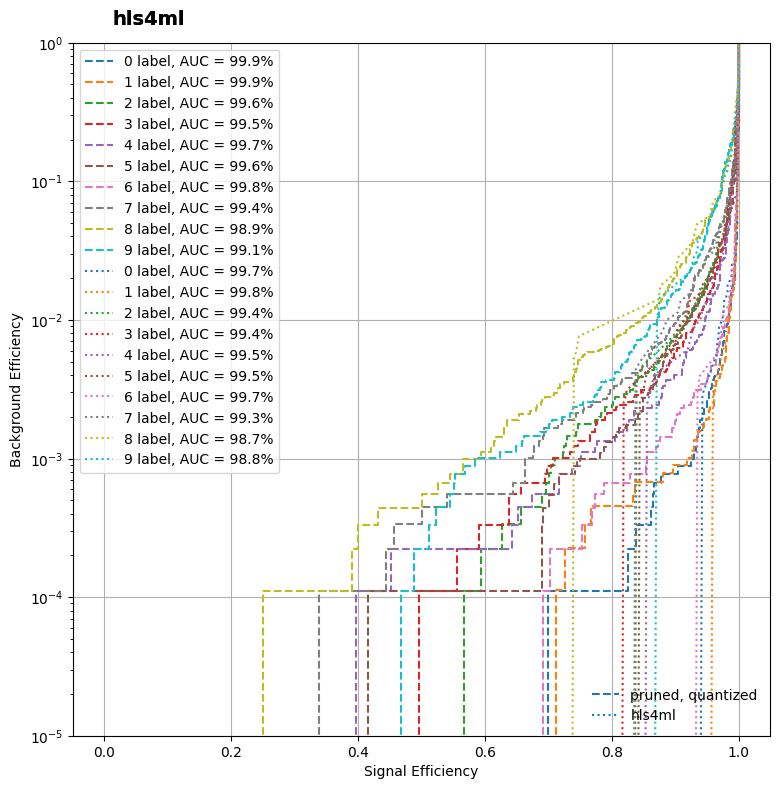

In [18]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

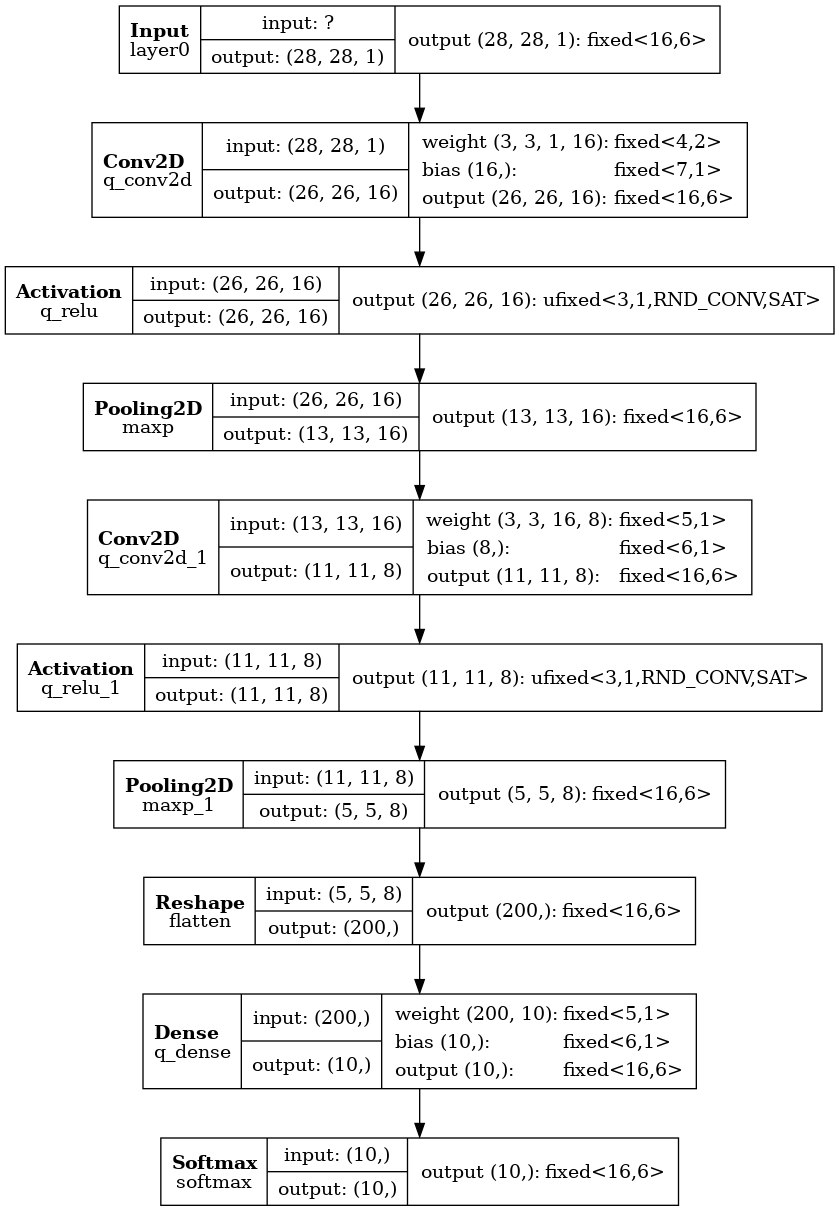

In [19]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Build the ip

In [20]:
hls_model.build(csim=False,synth=True,export=True,bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fang' on host 'fang-virtual-machine' (Linux_x86_64 version 6.5.0-27-generic) on Tue Apr 23 17:28:45 EDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/home/fang/PycharmProjects/cnn_bo/HLS_projectsQkeras_pruned_CNN/hls4ml_PYNQ_prj_three'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/fang/PycharmProjects/cnn_bo/HLS_projectsQkeras_pruned_CNN/hls4ml_PYNQ_prj_three/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '5.444',
  'BestLatency': '6273',
  'WorstLatency': '6273',
  'IntervalMin': '6274',
  'IntervalMax': '6274',
  'BRAM_18K': '73',
  'DSP': '100',
  'FF': '42537',
  'LUT': '40929',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.489,
  'TNS': 0.0,
  'WHS': 0.025,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [21]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_CNN/hls4ml_PYNQ_prj_three')

Found 1 solution(s) in /home/fang/PycharmProjects/cnn_bo/HLS_projectsQkeras_pruned_CNN/hls4ml_PYNQ_prj_three/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Tue Apr 23 17:31:12 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     5.444|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +------+------+------+------+----------+
    |   Latency   |   Interval  | Pipeline |
    |  min |  max |  min |  max |   Type   |
    +------+------+------+------+----------

In [50]:
hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)

AttributeError: module 'hls4ml' has no attribute 'templates'

In [22]:
with tf.device('/cpu:0'):
    %timeit y_qkeras = model.predict((x_test))

313/313 [==============================] - 1s 3ms/step
1.21 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### FPGA Comparison

Compute the output array in the fpga and save it as y_pynq

In [3]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from utils import plotting


#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
    
y_hls = np.load(DATA_PATH + 'y_hls_CNN.npy')

y_FPGA = np.load(DATA_PATH + 'y_pynq_CNN.npy', allow_pickle=True) 

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_FPGA, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]                )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':' )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_FPGA  , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='-.')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['qkeras_pruned', 'hls4ml', 'FPGA inf'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

fig.facecolor='yellow'

fig.savefig(PLOTS_PATH + '/Final_AUC_plot', bbox_inches='tight')

2024-04-23 18:38:31.683583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'model' is not defined

# Dense model

### Get the dataset

In [20]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Dense')

### Get the model

In [21]:
model = get_dense_qmodel()

model.summary()


Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.6525
    q_dense_1                      : 0.3429
    ----------------------------------------
    Total Sparsity                 : 0.6484
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (InputLayer)         [(None, 784)]             0         
                                                                 
 

/home/fang/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


In [10]:
pruning  = True

In [11]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=400)}
    model = prune.prune_low_magnitude(model, **pruning_params)

/home/gabri-bot/TFenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [12]:
train = False
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_Dense')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/cpu:0'):
        model.fit(x_train, y_train, batch_size=256,
                  epochs=50, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        if pruning:
            model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
q_relu (QActivation)         (None, 784)               0         
_________________________________________________________________
q_dense (QDense)             (None, 20)                15700     
_________________________________________________________________
q_relu_1 (QActivation)       (None, 20)                0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 10)                210       
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________

% of zeros = 0.75

Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.7671
    q_dense_1                      : 0.7190
    ----------------------------------------
    Total Sparsity                 : 0.7665


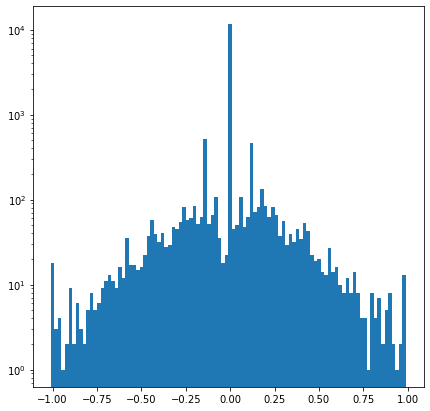

In [12]:
w = model.layers[2].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))



print_qstats(model)

Interpreting Model
Topology:
Layer name: layer0, layer type: Input
Layer name: q_relu, layer type: QActivation
Layer name: q_dense, layer type: QDense
Layer name: q_relu_1, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
XilinxPart:          xc7z020clg400-1
Board:               pynq-z2
ClockPeriod:         5
IOType:              io_parallel
HLSConfig
  Model
    ReuseFactor:     36
    Strategy:        Resource
    Precision:       ap_fixed<16,6>
  LayerName
    layer0
      Precision:     ap_ufixed<8,3>
    q_relu
      Precision
        result:      ap_fixed<2,1>
      ReuseFactor:   1
    q_dense
      Precision
        weight:      ap_fixed<4,1>
        bias:        ap_fixed<5,1>
      

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

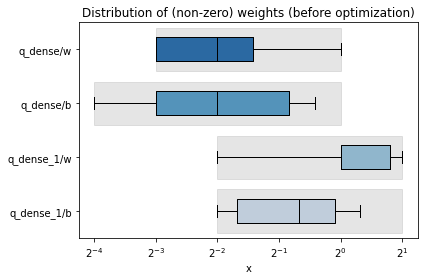

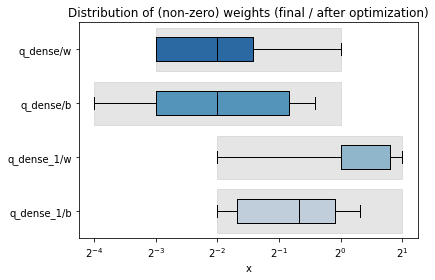

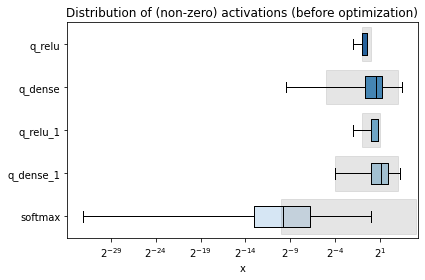

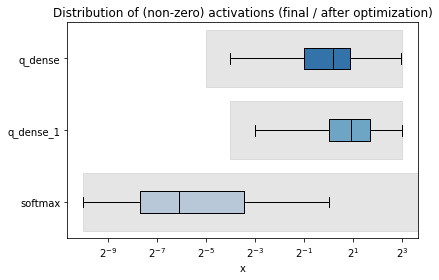

In [14]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'


Trace = True

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'

config['LayerName']['layer0']['Precision'] = 'ap_ufixed<8,3>'

config['LayerName']['q_dense']['ReuseFactor'] = 28
#config['LayerName']['q_dense']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_dense']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense']['Precision']['result']   = 'ap_fixed<9,4>'
config['LayerName']['q_dense']['Trace']       = Trace
#config['LayerName']['q_dense']['Strategy'] = 'Latency'

config['LayerName']['q_dense_1']['ReuseFactor'] = 20
#config['LayerName']['q_dense_1']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_dense_1']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense_1']['Precision']['result']   = 'ap_fixed<8,4>'
config['LayerName']['q_dense_1']['Trace']       = Trace
#config['LayerName']['q_dense_1']['Strategy'] = 'Latency'

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['table_size']  = 1024
#config['LayerName']['softmax']['Precision']   = 'ap_fixed<16,6>'
config['LayerName']['softmax']['Strategy']    = 'Stable'
config['LayerName']['softmax']['Trace']       = Trace


cfg = hls4ml.converters.create_config(part='xc7z020clg400-1', backend='VivadoAccelerator')
cfg['HLSConfig'] = config

cfg['AcceleratorConfig']['Driver']    = 'python'
cfg['AcceleratorConfig']['Board']     = 'pynq-z2'
cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
cfg['AcceleratorConfig']['Precision']['Input']  = 'float'
cfg['AcceleratorConfig']['Precision']['Output'] = 'float'

cfg['IOType']= 'io_parallel'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj'


print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])


#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                       hls_config=config,
#                                                       output_dir='model_3/hls4ml_prj',
#        

In [15]:
hls_model.compile()

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))

y_hls = hls_model.predict(np.ascontiguousarray(x_test))

Writing HLS project
Done


In [16]:
np.save(MODEL_PATH + 'Qkeras_pruned_Dense/HLS_data/y_hls.npy', y_hls)
np.save(DATA_PATH + 'y_hls_Dense.npy', y_hls)

Accuracy pruned, quantized: 0.9272
Accuracy hls4ml: 0.9142


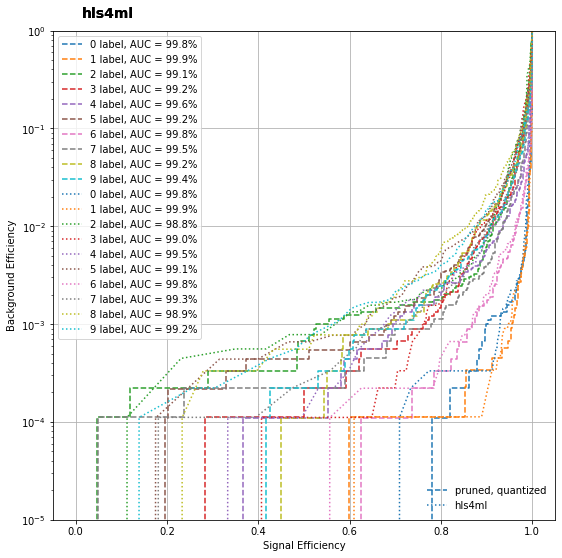

In [17]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

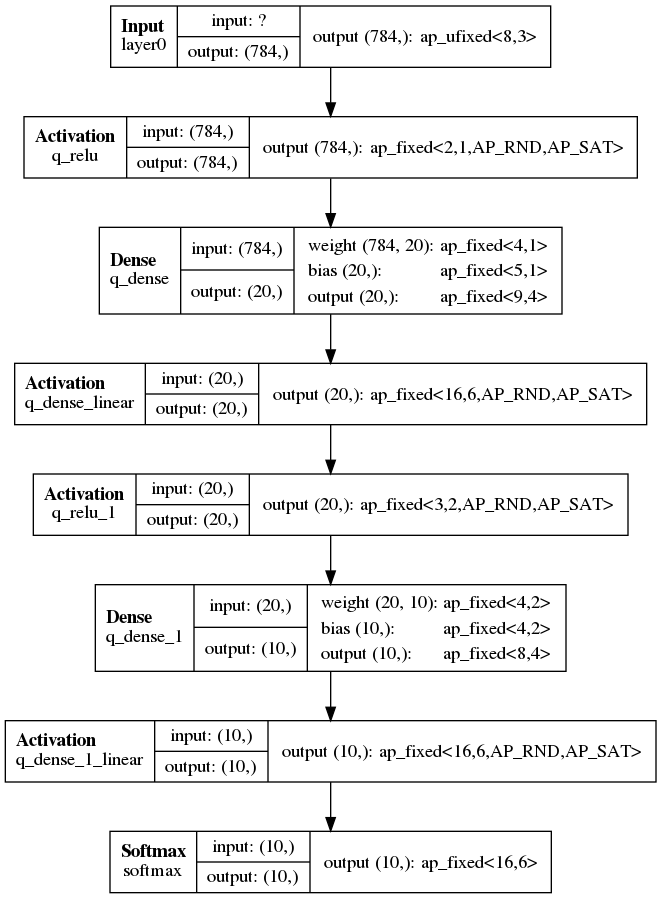

In [18]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.build(csim=False,synth=True,export=True)

In [20]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj')

Found 1 solution(s) in /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Fri Nov 12 10:38:45 2021

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.367 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max 

In [ ]:
hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)

In [ ]:
with tf.device('/cpu:0'):
    %timeit y_qkeras = model.predict((x_test))

Accuracy pruned, quantized: 0.9272
Accuracy hls4ml: 0.9142
Accuracy FPGA: 0.9141


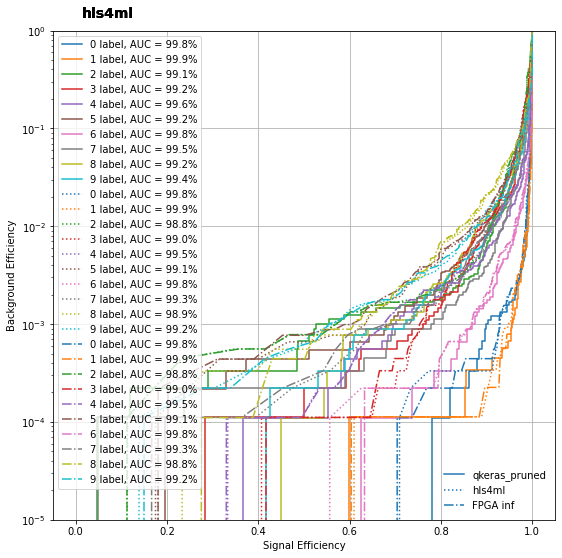

In [14]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from utils import plotting

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
    
y_hls = np.load(DATA_PATH + 'y_hls_Dense.npy')

y_FPGA = np.load(DATA_PATH + 'y_pynq_DNN.npy') 

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_FPGA, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]                )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':' )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_FPGA  , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='-.')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['qkeras_pruned', 'hls4ml', 'FPGA inf'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

fig.facecolor='yellow'

fig.savefig(PLOTS_PATH + '/Final_AUC_plot', bbox_inches='tight')